In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Generate seasonal synthetic data
np.random.seed(0)
n = 365 * 3  # 3 years of daily data
t = np.arange(n)
seasonal_pattern = 10 * np.sin(2 * np.pi * t / 365) + 5 * np.sin(4 * np.pi * t / 365)
trend = 0.05 * t
noise = np.random.normal(0, 3.5, n)
Y = seasonal_pattern + trend + noise

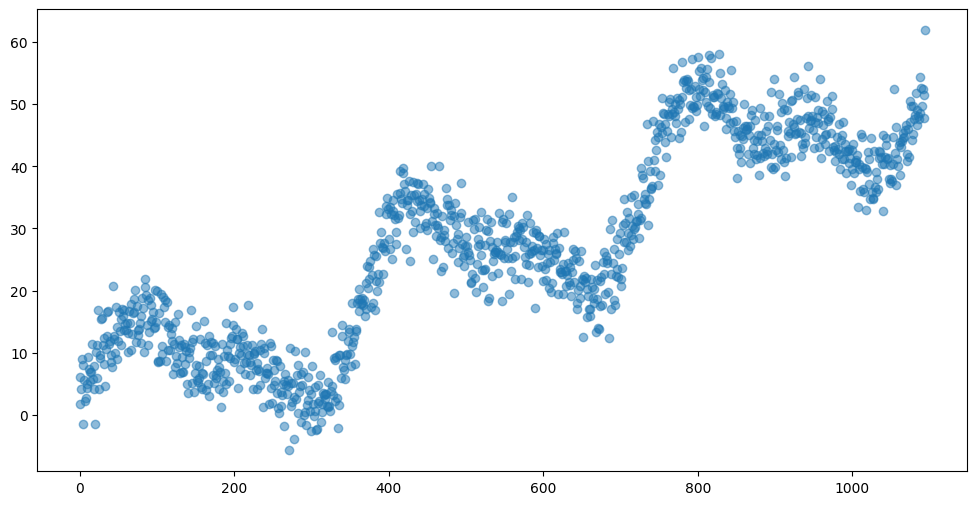

In [3]:
# Plot data and model fit
plt.figure(figsize=(12, 6))
plt.plot(t, Y, 'o', alpha=0.5, label='Observed data')

In [4]:
# Function to create Fourier features
def fourier_series(t, p=365.25, n=10):
    x = 2 * np.pi * np.arange(1, n+1) / p
    x = x * t[:, None]
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)

In [5]:
# Create Fourier features
X = fourier_series(t)

In [6]:
# Define and run the model
with pm.Model() as model:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=5)
    
    # Linear trend
    trend = pm.Normal('trend', mu=0, sigma=0.1)
    
    # Model specification
    mu = intercept + pm.math.dot(X, beta) + trend * t
    
    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    
    # Inference
    idata = pm.sample(2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [intercept, beta, sigma, trend]


/usr/local/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
# Print summary statistics
print(az.summary(idata, var_names=['intercept', 'trend', 'sigma']))

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -0.072  0.217  -0.488    0.348      0.004    0.003    2896.0   
trend      0.050  0.000   0.049    0.051      0.000    0.000    2836.0   
sigma      3.456  0.075   3.312    3.597      0.001    0.001    4737.0   

           ess_tail  r_hat  
intercept    3264.0    1.0  
trend        2805.0    1.0  
sigma        2623.0    1.0  


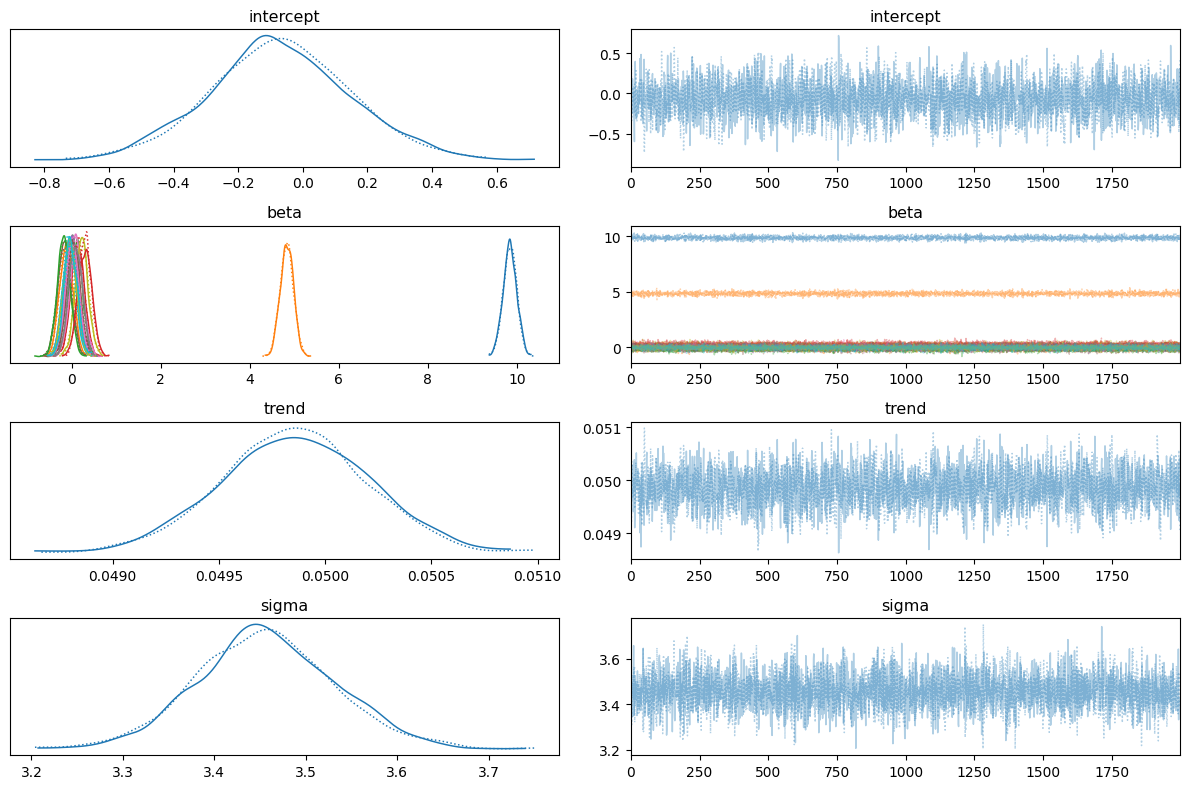

In [8]:
# Plot trace and posterior distributions
az.plot_trace(idata)
plt.tight_layout()
plt.show()

In [9]:
# Generate posterior predictive samples
ppc = pm.sample_posterior_predictive(idata, model=model, extend_inferencedata=True)

Sampling: [Y_obs]


/usr/local/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

<Axes: xlabel='Y_obs'>

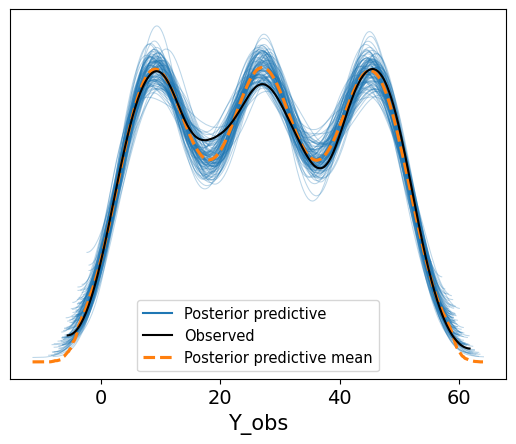

In [10]:
# Plot posterior predictive samples
az.plot_ppc(ppc, num_pp_samples=100, alpha=0.3)

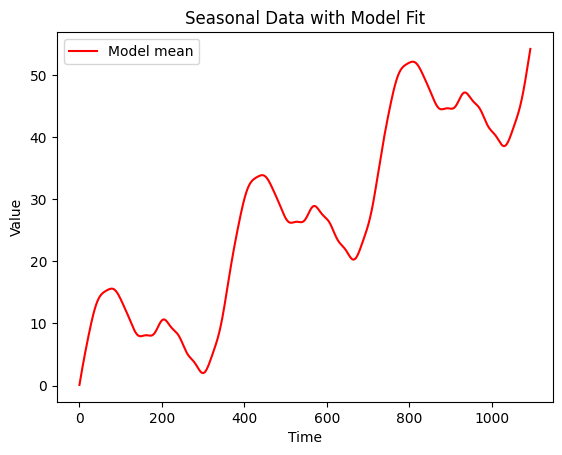

In [11]:
# Plot mean prediction
post_mean = az.summary(idata)['mean']
mean_prediction = (post_mean['intercept'] + 
                   np.dot(X, post_mean.filter(regex='^beta').values) + 
                   post_mean['trend'] * t)
plt.plot(t, mean_prediction, color='r', label='Model mean')

plt.legend()
plt.title('Seasonal Data with Model Fit')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

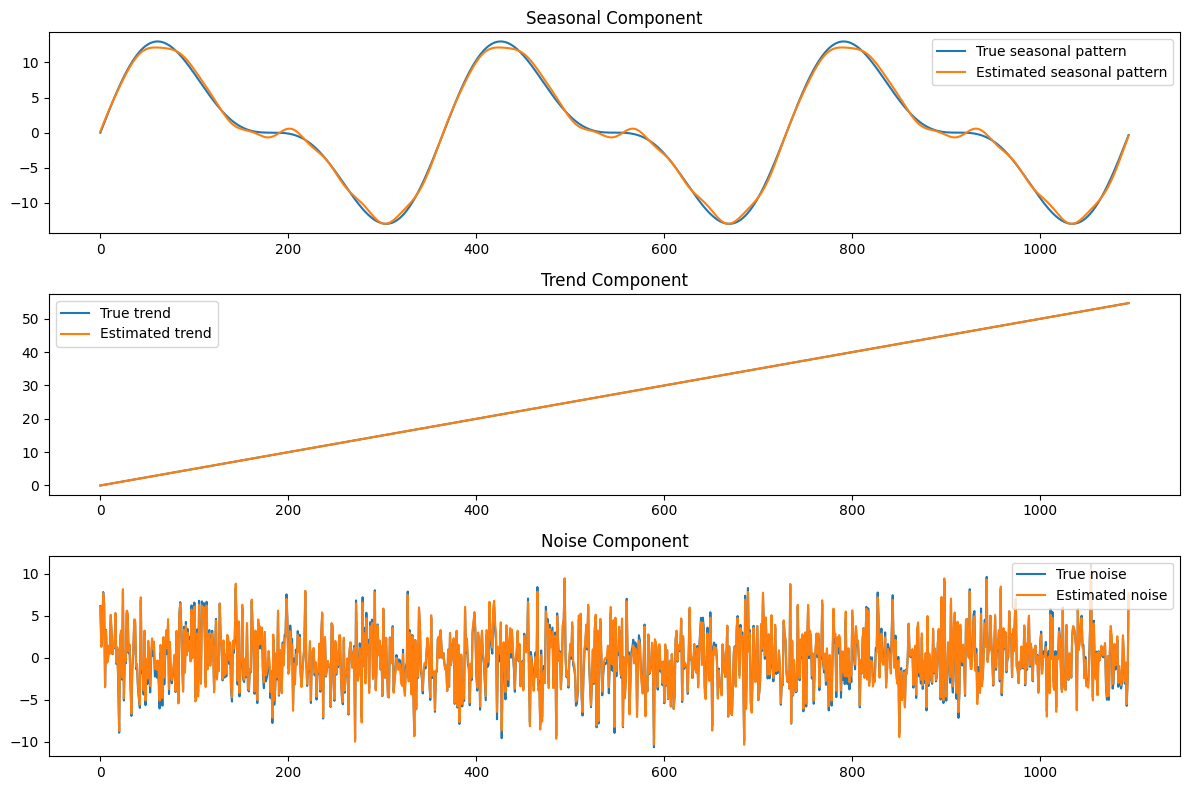

In [12]:
# Plot components
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(t, seasonal_pattern, label='True seasonal pattern')
plt.plot(t, np.dot(X, post_mean.filter(regex='^beta').values), label='Estimated seasonal pattern')
plt.legend()
plt.title('Seasonal Component')

plt.subplot(312)
# plt.plot(t, trend, label='True trend')
# plt.plot(t, post_mean['trend'] * t, label='Estimated trend')
# plt.legend()
# plt.title('Trend Component')
plt.plot(t, 0.05 * t, label='True trend')  # Use the original trend definition
plt.plot(t, post_mean['trend'] * t, label='Estimated trend')
plt.legend()
plt.title('Trend Component')

plt.subplot(313)
plt.plot(t, noise, label='True noise')
estimated_noise = Y - (np.dot(X, post_mean.filter(regex='^beta').values) + 
                       post_mean['trend'] * t + 
                       post_mean['intercept'])
plt.plot(t, estimated_noise, label='Estimated noise')
plt.legend()
plt.title('Noise Component')

plt.tight_layout()
plt.show()

In [13]:

# Print some additional information
print(f"N_eff / N_samples ratio for intercept: {az.ess(idata)['intercept'].mean() / len(idata.posterior.draw) * 100:.2f}%")
print(f"Rhat for intercept: {az.rhat(idata)['intercept'].mean():.3f}")

N_eff / N_samples ratio for intercept: 144.82%
Rhat for intercept: 1.000
